# Model Training & Testing
This notebook is intended to help train and test various models, and expanded from our data_model_prep notebook.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from fastai.tabular.all import *
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

import os
import pickle

random_state = 42

## Set up paths

In [2]:
# For python pipeline that will be run from root folder of project
# ROOT_DIR = os.path.abspath(os.curdir)

# # Pickle save paths
# training_df_path = os.path.join(ROOT_DIR,"data/processed/training_df.pkl")
# testing_df_path = os.path.join(ROOT_DIR,"data/processed/testing_df.pkl")

# Relative path for notebook
training_df_path = "../data/processed/training_df.pkl"
testing_df_path = "../data/processed/testing_df.pkl"

## Load training and test dataframes

In [3]:
training_df = pd.read_pickle(training_df_path)
testing_df = pd.read_pickle(testing_df_path)

## Columns for model training

In [4]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
    "view_like_ratio",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
    "neu",
    "neg",
    "pos",
    "compound",
]

y_col = "ld_score_ohe"

# Get all related columns - useful for fastai models
all_related_cols = X_cols.copy()
all_related_cols.append(y_col)

In [38]:
# Testing scaled versions
scaler = StandardScaler()
training_df_scaled_X = scaler.fit_transform(training_df[X_cols])
testing_df_scaled_X = scaler.transform(testing_df[X_cols])

## Helper Functions

In [6]:
def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    
    if len(y_test.unique()) > 2:
        average = "weighted"
    else:
        average = "binary"
        
    f1 = f1_score(y_test,testpreds,average=average)
    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 score: {f1}")
    return acc,f1

def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

## Model Training

### Random Forest

In [7]:
# Training model
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])

Random Forest metrics:
Accuracy Score: 0.8328328328328328
F1 score: 0.8082752404420278


RF Confusion Matrix
[[0.83443619 0.04055818 0.12500563]
 [0.28792763 0.15508994 0.55698243]
 [0.05154956 0.00763359 0.94081685]]


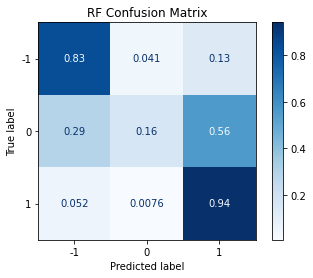

In [8]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

Random Forest-Scaled metrics:
Accuracy Score: 0.8330305614256232
F1 score: 0.8086059980948302
RF Confusion Matrix-Scaled
[[0.83466126 0.04127842 0.12406032]
 [0.28615993 0.15638973 0.55745035]
 [0.05138343 0.0077831  0.94083346]]


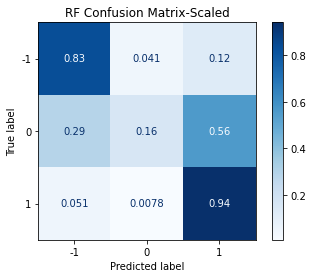

In [9]:
# Training model - scaled
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix-Scaled")

print("RF Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### GBM

In [10]:
# Training model
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df[X_cols],training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM",testing_df[X_cols],testing_df[y_col])

GBM metrics:
Accuracy Score: 0.8461547967720807
F1 score: 0.8213557660023547


GBM Confusion Matrix
[[0.8089129  0.05559307 0.13549404]
 [0.21857128 0.18545284 0.59597588]
 [0.03970462 0.00171112 0.95858426]]


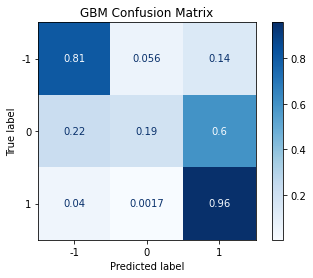

In [11]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix")

print("GBM Confusion Matrix")
print(disp.confusion_matrix)

GBM-Scaled metrics:
Accuracy Score: 0.8465440749391366
F1 score: 0.821778307917147
GBM Confusion Matrix-Scaled
[[0.80837272 0.05671843 0.13490885]
 [0.21753145 0.18644068 0.59602787]
 [0.03958833 0.00136225 0.95904941]]


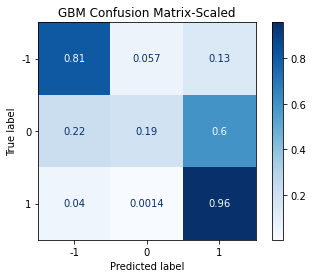

In [12]:
# Training model - scaled version
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df_scaled_X,training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM-Scaled",testing_df_scaled_X,testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df_scaled_X,
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix-Scaled")

print("GBM Confusion Matrix-Scaled")
print(disp.confusion_matrix)

### Neural Net
We will use sklearn mlp and fastai to create a tabular learner neural net

Iteration 1, loss = 5.03179586
Iteration 2, loss = 4.26178312
Iteration 3, loss = 3.72876109
Iteration 4, loss = 3.70338876
Iteration 5, loss = 3.28718026
Iteration 6, loss = 3.60041842
Iteration 7, loss = 3.68811624
Iteration 8, loss = 3.97759808
Iteration 9, loss = 3.63783898
Iteration 10, loss = 3.36762759
Iteration 11, loss = 3.69524900
Iteration 12, loss = 3.62926174
Iteration 13, loss = 3.58802954
Iteration 14, loss = 3.62091692
Iteration 15, loss = 3.69811208
Iteration 16, loss = 3.69174171
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLP metrics:
Accuracy Score: 0.7386336954238188
F1 score: 0.7295970292374239
MLP Confusion Matrix
[[0.90555931 0.02750394 0.06693675]
 [0.60803785 0.04559634 0.34636581]
 [0.16447516 0.01696999 0.81855485]]


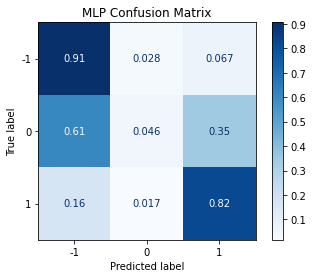

In [15]:
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=2)
mlp_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP",testing_df[X_cols],testing_df[y_col])

disp = ConfusionMatrixDisplay.from_estimator(
    mlp_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("MLP Confusion Matrix")

print("MLP Confusion Matrix")
print(disp.confusion_matrix)

In [13]:
# Starting with Sklearn MLP
# Training model
mlp_clf = MLPClassifier(random_state=random_state, max_iter=300, verbose=10)
mlp_clf.fit(training_df_scaled_X,training_df[y_col])

# Testing model
mlp_acc,mlp_f1 = test_model_metrics(mlp_clf,"MLP",testing_df_scaled_X,testing_df[y_col])

Iteration 1, loss = 0.53514842
Iteration 2, loss = 0.45536497
Iteration 3, loss = 0.43413238
Iteration 4, loss = 0.42127040
Iteration 5, loss = 0.41191944
Iteration 6, loss = 0.40513894
Iteration 7, loss = 0.39720523
Iteration 8, loss = 0.39029513
Iteration 9, loss = 0.38364579
Iteration 10, loss = 0.37750977
Iteration 11, loss = 0.37208525
Iteration 12, loss = 0.36731731
Iteration 13, loss = 0.36284929
Iteration 14, loss = 0.35874239
Iteration 15, loss = 0.35495807
Iteration 16, loss = 0.35159173
Iteration 17, loss = 0.34893355
Iteration 18, loss = 0.34573943
Iteration 19, loss = 0.34298140
Iteration 20, loss = 0.34075428
Iteration 21, loss = 0.33866099
Iteration 22, loss = 0.33608865
Iteration 23, loss = 0.33423255
Iteration 24, loss = 0.33255866
Iteration 25, loss = 0.33116157
Iteration 26, loss = 0.32937315
Iteration 27, loss = 0.32735971
Iteration 28, loss = 0.32701598
Iteration 29, loss = 0.32583173
Iteration 30, loss = 0.32456268
Iteration 31, loss = 0.32327241
Iteration 32, los

MLP Confusion Matrix-Scaled
[[0.75548053 0.0012154  0.24330407]
 [0.38327961 0.0083186  0.60840179]
 [0.09992607 0.00101338 0.89906055]]


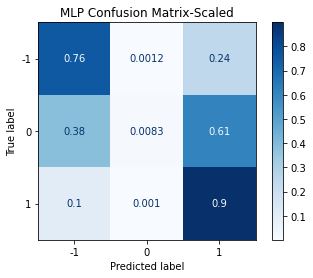

In [10]:
X_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound']

In [11]:
y_col

'ld_score_ohe'

In [12]:
all_related_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound',
 'ld_score_ohe']

In [215]:
# Create dataframe with all required columns
tab_df = training_df[all_related_cols].copy()

def remap_target(value):
    if value == -1:
        return "Negative"
    elif value == 0:
        return "Neutral"
    elif value == 1:
        return "Positive"

tab_df["ld_score_ohe"] = tab_df["ld_score_ohe"].apply(remap_target)

# Create tabular object and dataloaders
cat_names = ['age_limit','is_comments_enabled','is_live_content','cat_codes']
cont_names = ['duration', 'view_count', 'like_count','view_like_ratio','neu','neg','pos','compound']
procs = [Categorify, FillMissing, Normalize]

# Creates splits
splits = RandomSplitter(valid_pct=0.1)(range_of(tab_df))

to = TabularPandas(tab_df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=y_col,
                   y_block=CategoryBlock,
                   splits=splits)

dls = to.dataloaders(bs=2048)

In [216]:
# Create weighted f1 score by modifying fastai f1 score
# def F1Score(axis=-1, labels=None, pos_label=1, average='weighted', sample_weight=None):
#     "F1 score for single-label classification problems"
#     return skm_to_fastai(skm.f1_score, axis=axis,
#                          labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

In [217]:
cross_entropy_loss_flat = CrossEntropyLossFlat()
f1_score_fai = F1Score()
f1_score_multi = F1ScoreMulti(average="weighted")

In [218]:
# Create tabular learner
learn_tab = tabular_learner(dls, layers=[100,200,100], metrics=accuracy,loss_func=cross_entropy_loss_flat)

SuggestedLRs(valley=0.0008317637839354575)

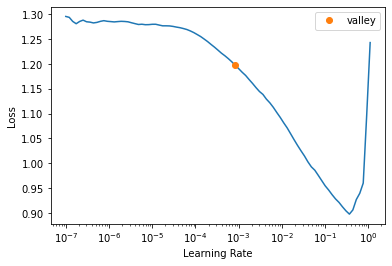

In [219]:
# Fastai has a useful function to estimate the best learning rate to use.
learn_tab.lr_find()

In [220]:
# Fit the data. We are not fine-tuning here. We are learning from our training data alone.
learn_tab.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.537413,0.770312,0.726088,00:05
1,0.387218,1.062577,0.732909,00:05
2,0.352577,1.069417,0.718311,00:05
3,0.318735,1.123301,0.733351,00:05
4,0.308855,0.992836,0.732296,00:05


In [221]:
tab_test_df = testing_df[X_cols].copy()
tab_test_dl = learn_tab.dls.test_dl(tab_test_df,ordered=True)

In [222]:
preds, _, decoded = learn_tab.get_preds(dl=tab_test_dl, with_decoded=True)

In [223]:
decoded

tensor([2, 2, 2,  ..., 2, 2, 2])

In [224]:
decoded.unique()

tensor([0, 1, 2])

In [225]:
decoded[decoded == 0] = -1
decoded[decoded == 1] = 0
decoded[decoded == 2] = 1

In [226]:
decoded.unique()

tensor([-1,  0,  1])

In [227]:
f1_score(testing_df[y_col],decoded,average="weighted")

0.6423349568038629